# Mixture Density Network
 

# Outline

This is an excerpt from the Kadenze Training course, Creative Applications of Tensorflow II - Mixture Density Networks.

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
- [Introduction](#mgd)
- [Gaussian Mixtures](#gaussian_mixtures)
- [Code - Inituitive Explanation](#code)
    - [Mixture Model with Single Gaussian](#mgd_single)
    - [Mixture Model with Multiple Gaussians](#mgd_multiple)
<!-- /MarkdownTOC -->

<a name="mgd"></a>
## Introduction

### Typical Vanilla Neural Network
Consider a typical regression network to synthesize an image:
- A network that uses 2 inputs - the X and Y position of a canvas, or the row and column of an image
- It predicts the output R, G, and B values of the image. 
- The model tries to optimize only one possible R, G, and B value for every possible input X and Y value.
- This makes a lot of assumptions about the objective of the model.

#### Caveat:
How does the network model two or more images? (i.e. two imgaes)
- The network is unable to express multiple possibilities, only one possible output.
- It tries to optimize for some measure such as l1 or l2-loss.
- It tries to minimize the average error for the observations.
- The network would model the average distribution of the observed values to create the most optimal l1 or l2 loss.
- The distribution of the l1/l2 loss function is capable of unimodal modelling - there is only one peak.
- But the true distribution has two peaks - the two true values to predict an RGB given an X, Y value.
- This results in a model distribution that has a single peak that sits in between the two (not ideal).

### Softmax Function
The above is an example of a model that expresses one-to-one possibilities. The softmax function can express one-to-many possibilities:
- It has the ability to model an arbitrary probability distribution. 
- The function is capable of expressing multiple explanations in terms of a probability.
- This is an arbitrary distribution defined by the density of our data observations.

#### Caveat
That may be exactly what we want to do when we have multiple possible explanations for the same input. However, it might also be the case that this distribution is still too noisy, or encompasses too many parameters to be useful.

An example - modelling handwriting based on a softmax function:
- Objective - Model the letter that is being written given the X and Y position of a pen.
- The softmax function would have to define every possible position of x and y, and the model the distribution of the possible Xs and Ys. 
- This might entail modeling thousands to millions of pixels, equating to a higher number of output neurons.

Instead, we could think about the outputs in terms of much fewer values which would define the entire distribution of the same space; and the mixture density network which models a complex distribution using just a few parameters, satisfies this requirement

<a name="gaussian_mixtures"></a>
## Gaussian Mixtures

A Gaussian Mixture Model (GMM) is a parametric probability density function represented as a weighted sum of Gaussian component densities. GMMs are commonly used as a parametric model of the probability distribution of continuous measure-
ments or features in a biometric system, such as vocal-tract related spectral features in a speaker recognition system.
GMM parameters are estimated from training data using the itera tive Expectation-Maximization (EM) algorithm or Maximum Posterior (MAP) estimation from a well-trained prior model.

To define a Gaussian, the mean and the standard deviation need to have definitions.

### Mean and Standard Deviation
- The mean describes the peak of the distribution - the most probable outcome of our distribution.
- The standard deviation describes the uncertainty in the mean - a high standard deviation equates to a lower belief in the mean, allowing for values farther and farther away from the mean.

### Gaussian Weight
- A weight term applied to each one of them to say how likely each one is.
- A high weight means it is more likely that Gaussian is more predictive of what will happen

<a name="code"></a>
# Code - Intuitive Explanation

Let's load the required libraries

In [1]:
import sys
# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
    import tensorflow.contrib.layers as tfl
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, datasets, dataset_utils
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

Make sure you have started notebook in the same directory as the provided zip file which includes the 'libs' folder and the file 'utils.py' inside of it.  You will NOT be able to complete this assignment unless you restart jupyter notebook inside the directory created by extracting the zip file or cloning the github repo.


And prepare the training data:

((16384, 2), (16384, 3))

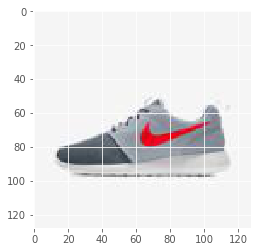

In [2]:
img_file = 'img_shoes/pwp_sheet_prem_005_1.jpg'
img = plt.imread(img_file)

# We'll first collect all the positions in the image in our list, xs
xs = []

# And the corresponding colors for each of these positions
ys = []

# Now loop over the image
for row_i in range(img.shape[0]):
    for col_i in range(img.shape[1]):
        # And store the inputs
        xs.append([row_i, col_i])
        # And outputs that the network needs to learn to predict
        ys.append(img[row_i, col_i])

# we'll convert our lists to arrays
xs = np.array(xs)
ys = np.array(ys)

# Normalizing the input by the mean and standard deviation
xs = (xs - np.mean(xs)) / np.std(xs)
ys = (ys / 255.0)

plt.imshow(img)
# and print the shapes
xs.shape, ys.shape

For the model. we instantiate placeholders for X and Y.

In [3]:
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 3], name='Y')

Let's define the model's layer configuration

In [4]:
n_neurons = [2, 128, 128]

<a name="mgd_single"></a>
## Mixture Model with Single Gaussian
Instead of having 3 output values corresponding to the R, G, B values, we want the output values to correspond to the Mixture Density Network's values. For a single Gaussian, this is simply the mean and standard deviation of each of our features. If we had multiple Gaussians, then we'd need a mean and standard deviation for each of our Gaussians, as well as a weight parameter for each of the Gaussians for a single output. We'll see how that works in just a moment, but for now, let's see the single Gaussian case.

In [5]:
current_input = X
for layer_i in range(1, len(n_neurons)):
    current_input = tfl.linear(
        inputs=current_input,
        num_outputs=n_neurons[layer_i],
        activation_fn=tf.nn.relu, 
        scope='layer/' + str(layer_i))

Now instead of going to 3 values for our RGB values, we want to have an output for the mean value of our 3 RGB values as well as their standard deviations. We'll use the name "sigma" for our standard deviations which is the mathematical symbol commonly used to denote standard deviation. You may have come across the term variance which is simply the squared value of this.

In [6]:
means = tfl.linear(inputs=current_input,
                   num_outputs=3,
                   activation_fn=tf.nn.relu,
                   scope='means')
sigmas = tf.maximum(tfl.linear(inputs=current_input,
                    num_outputs=3,
                    activation_fn=tf.nn.relu,
                    scope='sigmas'), 1e-10)

Now we have the two components that make up a Gaussian, the mean and standard deviation.

We can use this Neural Network to predict as its output a Gaussian distribution. If we want to enforce that the mean be a certain range, for instance only positive in the case of color values, we can normalize our images from 0-1, and then have the mean be a sigmoid output. Similarly for the standard deviation, we can use our understanding of what a typical standard deviation should be to understand which activation function to use. For instance, the standard deviation cannot be negative. We also know that the standard deviation should be fairly small. So we could also make use of a sigmoid output for our standard deviation.

When we introduce additional mixtures, we'll create what's called a mixture of Gaussians. This is simply just the linear combination of multiple Gaussians. For now, we have 1 Gaussian for each feature. But later, we'll see how we can use many Gaussians for each feature, or what's called a mixture model. For a mixture model, we'll need to have a separate output for the mean and standard deviation of each component of the mixture. So we'll have for instance 3 means for two Gaussian components, and 3 standard deviations. But we'll also need to include a set of mixing coefficients which describe how to weight each of the Gaussian components. We have to ensure that these add up to 1. We can easily enforce this using a softmax on the output neurons specifying the weights.

For now let's keep it simple and use 1 Gaussian per feature. We're almost there. We just have to build our cost function. In order to understand what our Gaussian function thinks, we use what's called a probability density function. This function says what the likelihood of any given value is as determined by the Gaussian. A Normal curve has a mean of 0 and sigma of 1. It's probability density function looks like this:

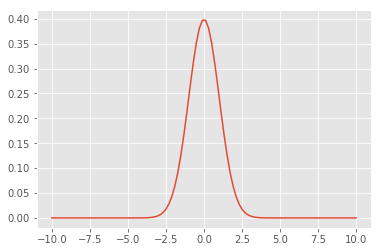

In [7]:
def normpdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

xvals = np.linspace(-10, 10, 100)
plt.plot(xvals, normpdf(xvals))

Below is the generic equation for a Gaussian Probability Density Function:

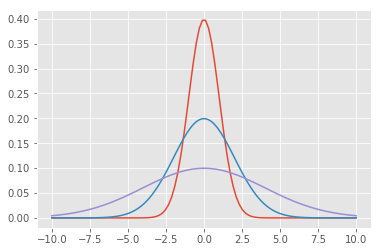

In [8]:
def gausspdf(x, mean=0, sigma=1):
    return np.exp(-(x - mean)**2 / (2 * sigma**2)) / (np.sqrt(2.0 * np.pi) * sigma)

xvals = np.linspace(-10, 10, 100)
plt.plot(xvals, gausspdf(xvals))
plt.plot(xvals, gausspdf(xvals, 0, 2.0))
plt.plot(xvals, gausspdf(xvals, 0, 4.0))

We have 3 features which we are treating independently, which means there is no dependency between each of the Gaussians. A more complex Gaussian model can actually take into account what the Red Gaussian is doing in order to better understand what the Green Gaussian should do, for instance. These are called co-variances rather than simple variances. We'll keep it simple for now but just know that what we are doing is equivalent to a matrix version of the Gaussian's sigma in what's called a diagonal covariance, since if we view the variance as a matrix with rows and columns for each of our features, only the diagonal has values.

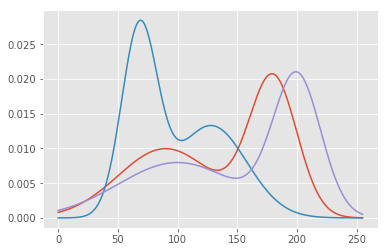

In [9]:
xvals = np.linspace(0, 255, 255)
plt.plot(
    np.repeat(xvals[:, np.newaxis], 3, axis=1),
    np.c_[gausspdf(xvals, 180, 20) +
            gausspdf(xvals, 90, 40),
          gausspdf(xvals, 128.0, 30.0) +
            gausspdf(xvals, 68.0, 15.0),
          gausspdf(xvals, 100, 50.0) +
            gausspdf(xvals, 200, 20.0)])

But we'll also have to add weights so that their sum still equals one:

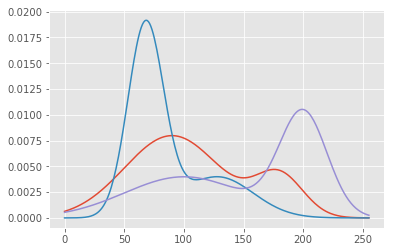

In [10]:
xvals = np.linspace(0, 255, 255)
plt.plot(
    np.repeat(xvals[:, np.newaxis], 3, axis=1),
    np.c_[0.2 * gausspdf(xvals, 180, 20) + 
            0.8 * gausspdf(xvals, 90, 40),
          0.3 * gausspdf(xvals, 128.0, 30.0) +
            0.7 * gausspdf(xvals, 68.0, 15.0),
          0.5 * gausspdf(xvals, 100, 50.0) +
            0.5 * gausspdf(xvals, 200, 20.0)])

Which we can confirm by adding the entire PDF curve:

In [11]:
np.sum(0.2 * gausspdf(xvals, 180, 20) + 0.8 * gausspdf(xvals, 90, 40))
np.sum(0.3 * gausspdf(xvals, 128.0, 30.0) + 0.7 * gausspdf(xvals, 68.0, 15.0))
np.sum(0.5 * gausspdf(xvals, 100, 50.0) + 0.5 * gausspdf(xvals, 200, 20.0))

0.98317739777343105

Now that we have a measure of how confident we are in any given value, using our PDF, we can try to optimize for being confident about the true values we want our network to predict. For instance if the true color value of pixel location (200, 200) is (30, 100, 50) for red, green, and blue, then we'll want our PDF for red to have a sharp peak at the value of 30, and very little variance, similarly for the PDF of green and blue. Now let's say that we had as true color values for pixel location (200, 200) two possible colors, perhaps as a result of training our network with 2 different images. What would our Gaussian PDF look like then? We'd need peaks at each color that was possible. However, with just 1 Gaussian for each color, we wouldn't be able to model that except for reducing our confidence in each value by increasing the variance.

In order to measure confidence, we could directly use the PDF and maximize the probability of the true value. However, it is more common to use the log likelihood. There are many reasons for doing so. For one, log is a monotonically increasing function of its argument, meaning by maximizing the log likelihood we still end up maximizing the likelihood. It is also numerically more stable when dealing with very small numbers, which probabilities tend to be! Small probabilities, when mixed with gradients, can easily underflow the numerical precision that we are able to represent. So what we often do in machine learning applications is maximize the log likelihood. We can either maximize the log likelihood, or instead minimize the negative log likelihood, which is what is often done w/ neural networks.

Let's see how to code up our cost function using the PDF. We first need a tensorflow version of the gausspdf function we just wrote:

In [12]:
def gausspdf(x, mean, sigma):
   return tf.exp(-(x - mean)**2 / (2 * sigma**2)) / (tf.sqrt(2.0 * np.pi) * sigma)

Now we can find the likelihoods of our true color values in Y as measured by our Gaussians stored in means and sigmas.

In [13]:
p = gausspdf(Y, means, sigmas)

And we can measure the negative log likelihood by simply taking the negative log. But we'll also ensure that we do not take log of 0, which is undefined, and clip the lower range to a fairly small value.

In [14]:
negloglike = -tf.log(tf.maximum(p, 1e-10))

Finally we can measure the cost by adding the NLLs of each of our Gaussians per observation, and looking at the mean negative log likelihood.

In [15]:
cost = tf.reduce_mean(tf.reduce_mean(negloglike, 1))

The rest should be familiar. We'll create an optimizer and train. The only difference with this network and the original one other than predicting a distribution rather than the actual values is the way we "infer" from the network. Typically we would just use the output of the network. But now we'll need to do something like what we've done w/ our softmax in the char-rnn model. We'll need to sample the distribution. We can simply pick the most probable element in the distribution, which for a single Gaussian is the mean value. Or, we can sample with a likelihood determined by the Gaussian. In that case, we need to use our PDF to determine the chances of drawing the mean. Perhaps with a large variance, there isn't actually a very good chance of drawing the mean.

Iteration:  19 / 100 , cost:  -1.08119


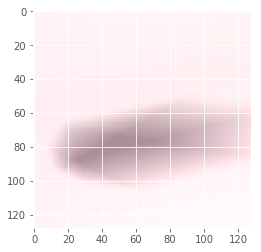

Iteration:  39 / 100 , cost:  -0.837651


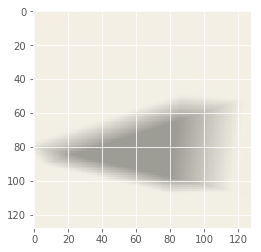

Iteration:  59 / 100 , cost:  -1.39661


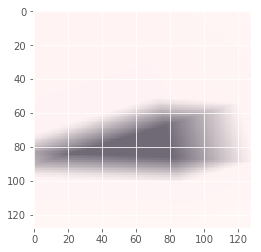

Iteration:  79 / 100 , cost:  -1.17904


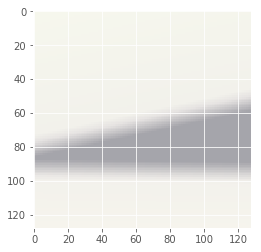

Iteration:  99 / 100 , cost:  -1.15812


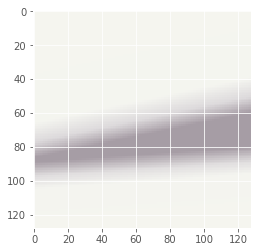

In [17]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

n_iterations = 100
batch_size = 50
init_op = tf.global_variables_initializer()
fig, ax = plt.subplots(1, 1)
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(init_op)
    # We now run a loop over epochs
    prev_training_cost = 0.0
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})
        this_cost = sess.run(
            cost, feed_dict={X: xs, Y: ys})
        if (it_i + 1) % 20 == 0:
            print('Iteration: ', it_i,'/', n_iterations, ', cost: ', this_cost)
            ys_pred = means.eval(feed_dict={X: xs}, session=sess)
            img = np.clip(ys_pred.reshape(img.shape), 0, 1)
            plt.imshow(img)
            plt.show()

Now let's try to do the same thing but with more than 1 image. We'll still use one Gaussian per color feature.

Iteration:  19 / 100 , cost:  -0.838835


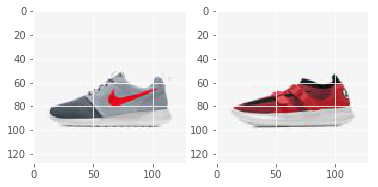

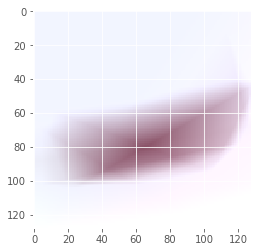

Iteration:  39 / 100 , cost:  0.317265


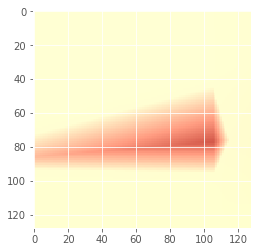

Iteration:  59 / 100 , cost:  -0.302423


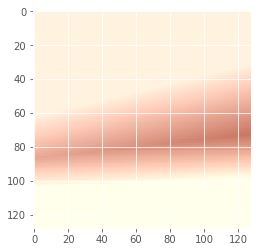

Iteration:  79 / 100 , cost:  0.128686


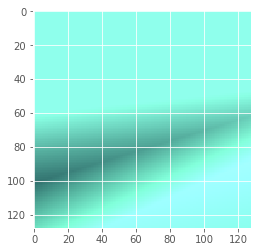

Iteration:  99 / 100 , cost:  -0.253925


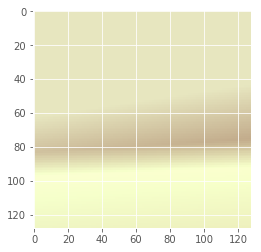

In [19]:
img_file1 = 'img_shoes/pwp_sheet_prem_005_1.jpg'
img1 = plt.imread(img_file1)
img_file2 = 'img_shoes/pwp_sheet_prem_003_0.jpg'
img2 = plt.imread(img_file2)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img1)
axs[1].imshow(img2)

# We'll first collect all the positions in the image in our list, xs
xs = []

# And the corresponding colors for each of these positions
ys = []

# Now loop over the image
for row_i in range(img1.shape[0]):
    for col_i in range(img1.shape[1]):
        # And store the inputs
        xs.append([row_i, col_i])
        # And outputs that the network needs to learn to predict
        ys.append(img1[row_i, col_i])
        # And store the inputs
        xs.append([row_i, col_i])
        # And outputs that the network needs to learn to predict
        ys.append(img2[row_i, col_i])

# we'll convert our lists to arrays
xs = np.array(xs)
ys = np.array(ys)

# Normalizing the input by the mean and standard deviation
xs = (xs - np.mean(xs, 0, keepdims=True)) / np.std(xs, 0, keepdims=True)
ys = (ys / 255.0)

# and print the shapes
xs.shape, ys.shape

n_iterations = 100
batch_size = 50
init_op = tf.global_variables_initializer()
fig, ax = plt.subplots(1, 1)
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(init_op)
    # We now run a loop over epochs
    prev_training_cost = 0.0
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})
        this_cost = sess.run(
            cost, feed_dict={X: xs, Y: ys})
        if (it_i + 1) % 20 == 0:
            print('Iteration: ', it_i,'/', n_iterations, ', cost: ', this_cost)
            ys_pred = means.eval(feed_dict={X: xs[::2]}, session=sess)
            img = np.clip(ys_pred.reshape(img.shape), 0, 1)
            plt.imshow(img)
            plt.show()

<a name="mgd_multiple"></a>
## Mixture Model with Multiple Gaussians

Let's reset the graph and re-initialise the placeholders.

The network configuration is as follow:
    - Neurons per layer: [2, 100, 100, 100, 100, 100, 50]
    - Feature number: 3
    - Gaussians per feature: 10
    - Dropout keep probability: 0.8

In [268]:
tf.reset_default_graph()
n_neurons = [10, 100, 100, 100, 100, 100, 50]
dropout = False
keep_prob = 0.5
X = tf.placeholder(tf.float32, shape=[None, 2], name='X')
Y = tf.placeholder(tf.float32, shape=[None, 3], name='Y')

The training data consists of 5 shoe images

img_shoes\pwp_sheet2_0.jpg
img_shoes\pwp_sheet2_002_0.jpg
img_shoes\pwp_sheet2_002_1.jpg
img_shoes\pwp_sheet2_003_0.jpg
img_shoes\pwp_sheet2_004_0.jpg


((81920, 2), (81920, 3))

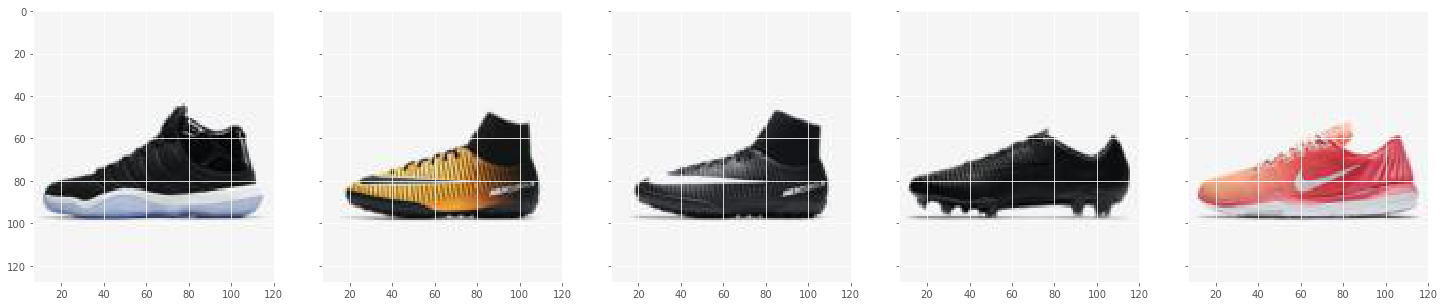

In [269]:
def get_images(directory='.'):
    # Create a directory
    if not os.path.exists(directory):
        return None

    files = [os.path.join(directory, file_i)
             for file_i in os.listdir(directory)
             if '.jpg' or '.png' in file_i]
    return files

# img_file1 = 'img_shoes/pwp_sheet_prem_005_1.jpg'
# img1 = plt.imread(img_file1)
# img_file2 = 'img_shoes/pwp_sheet_prem_003_0.jpg'
# img2 = plt.imread(img_file2)
# fig, axs = plt.subplots(1, 2)
# axs[0].imshow(img1)
# axs[1].imshow(img2)

# We'll first collect all the positions in the image in our list, xs
xs = []

# And the corresponding colors for each of these positions
ys = []

file_n = 5
files = get_images('img_shoes')
files = files[:file_n]


f, ax1 = plt.subplots(1, file_n, sharey=True, figsize=(25, 5))


for i, f in enumerate(files):
    img1 = plt.imread(f)
    print(f)
    ax1[i].imshow(img1)
    # Now loop over the image
    for row_i in range(img1.shape[0]):
        for col_i in range(img1.shape[1]):
            # And store the inputs
            xs.append([row_i, col_i])
            # And outputs that the network needs to learn to predict
            ys.append(img1[row_i, col_i])

# we'll convert our lists to arrays
xs = np.array(xs)
ys = np.array(ys)

# Normalizing the input by the mean and standard deviation
xs = (xs - np.mean(xs, 0, keepdims=True)) / np.std(xs, 0, keepdims=True)
ys = (ys / 255.0)

# and print the shapes
xs.shape, ys.shape

And recreate the layers:

In [270]:
current_input = X
for layer_i in range(1, len(n_neurons)):
    current_input = tfl.linear(
        inputs=current_input,
        num_outputs=n_neurons[layer_i],
        activation_fn=tf.nn.relu, 
        scope='layer/' + str(layer_i))
    print('layer/' + str(layer_i) +'')
    if dropout:
        current_input = tf.nn.dropout(current_input, keep_prob)
        print('dropout layer/' + str(layer_i) +', keep_prob: ', keep_prob)

n_features = 3
n_gaussians = 10

means = tf.reshape(
    tfl.linear(inputs=current_input,
               num_outputs=n_features * n_gaussians,
               activation_fn=tf.nn.relu,
               scope='means'), [-1, n_features, n_gaussians])
sigmas = tf.maximum(
    tf.reshape(
        tfl.linear(inputs=current_input,
                   num_outputs=n_features * n_gaussians,
                   activation_fn=tf.nn.relu,
                   scope='sigmas'), [-1, n_features, n_gaussians]), 1e-10)
weights = tf.reshape(
    tfl.linear(inputs=current_input,
               num_outputs=n_features * n_gaussians,
               activation_fn=tf.nn.softmax,
               scope='weights'), [-1, n_features, n_gaussians])

layer/1
layer/2
layer/3
layer/4
layer/5
layer/6


To measure our cost, we'll need to make use of our 3-dimensional Tensors and broadcasting. We'll need to convert our Y placeholder to a 3-dimensional array, so that the dimension for the n_gaussians is broadcasted, and we get a measure of error for each of our Gaussians.

In [271]:
Y_3d = tf.reshape(Y, [-1, n_features, 1])

Now we can measure the cost like before:

In [272]:
p = gausspdf(Y_3d, means, sigmas)

And apply the weighting on each Gaussian:

In [273]:
weighted = weights * p

And find the sum across all Gaussians:

In [274]:
sump = tf.reduce_sum(weighted, 2)

The rest is exactly the same. We'll compute the negative log likelihood, cost, and train.

In [275]:
negloglike = -tf.log(tf.maximum(sump, 1e-10) + 1)

Finally we can measure the cost by adding the NLLs of each of our Gaussians per observation, and looking at the mean negative log likelihood.

The training parameters are as follow:
    - Iterations: 300
    - Batch size per iteration: 200
    - Learning rate: 0.01

In [276]:
import imageio
import time

current_time = time.strftime('%Y%m%d_%H%M%S', time.gmtime())
model_img_dir = "data/model_imgs/MGD_NeuralNet/" + current_time
if not os.path.exists(model_img_dir):
    os.makedirs(model_img_dir)
cost = tf.reduce_mean(tf.reduce_mean(negloglike, 1))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)
imgs = []
n_iterations = 300
batch_size = 200
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    # Here we tell tensorflow that we want to initialize all
    # the variables in the graph so we can use them
    # This will set W and b to their initial random normal value.
    sess.run(init_op)
    # We now run a loop over epochs
    prev_training_cost = 0.0
    for it_i in range(n_iterations):
        idxs = np.random.permutation(range(len(xs)))
        n_batches = len(idxs) // batch_size
        for batch_i in range(n_batches):
            idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]
            sess.run(optimizer, feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})
        this_cost = sess.run(
            cost, feed_dict={X: xs, Y: ys})
        if (it_i + 1) % 5 == 0:
            img = None
            print('Iteration: ', it_i + 1,'/', n_iterations, ', cost: ', this_cost)
            y_mu, y_dev, y_pi = sess.run([means, sigmas, weights],
                feed_dict={X: xs[0:16384]})
            if False:
                ys_pred = np.sum(y_mu * y_pi, axis=2)
                img = np.clip(ys_pred, 0, 1)
            else:
                ys_pred = np.array(
                    [y_mu[obv, :, idx]
                    for obv, idx in enumerate(np.argmax(y_pi.sum(1), 1))])
                img = np.clip(ys_pred.reshape(img1.shape), 0, 1)

            if img is not None:
                plt.imsave(fname=os.path.join(model_img_dir, 'mgd_'+str(it_i)+'.jpg'), arr=img.reshape(img1.shape))

Iteration:  5 / 300 , cost:  -0.00402468
Iteration:  10 / 300 , cost:  -0.250897
Iteration:  15 / 300 , cost:  -0.00295738
Iteration:  20 / 300 , cost:  -0.0988252
Iteration:  25 / 300 , cost:  -0.112147
Iteration:  30 / 300 , cost:  -0.112191
Iteration:  35 / 300 , cost:  -0.112428
Iteration:  40 / 300 , cost:  -0.112809
Iteration:  45 / 300 , cost:  -0.111255
Iteration:  50 / 300 , cost:  -0.627457
Iteration:  55 / 300 , cost:  -0.081749
Iteration:  60 / 300 , cost:  -0.0792802
Iteration:  65 / 300 , cost:  -0.0787413
Iteration:  70 / 300 , cost:  -0.44613
Iteration:  75 / 300 , cost:  -0.405817
Iteration:  80 / 300 , cost:  -0.133508
Iteration:  85 / 300 , cost:  -0.0877597
Iteration:  90 / 300 , cost:  -0.0878801
Iteration:  95 / 300 , cost:  -0.0909639
Iteration:  100 / 300 , cost:  -0.0861582
Iteration:  105 / 300 , cost:  -0.203273
Iteration:  110 / 300 , cost:  -0.0865134
Iteration:  115 / 300 , cost:  -0.980493
Iteration:  120 / 300 , cost:  -0.594176
Iteration:  125 / 300 , c

In [277]:
file_n = 5
shoe_files = get_images('img_shoes')
shoe_files = shoe_files[:file_n]

img_shoe_stack = np.array([])
for i, fi in enumerate(shoe_files):
    img1 = plt.imread(fi)
    if img_shoe_stack.shape[0] == 0:
        img_shoe_stack  = img1
    else:
        img_shoe_stack = np.hstack((img_shoe_stack, img1))

train_files = [os.path.join(model_img_dir, file_i)
    for file_i in os.listdir(model_img_dir)
    if '.jpg' or '.png' in file_i]


train_img_stack = []
for i, f in enumerate(train_files):
    img1 = plt.imread(f)
    train_img_stack.append(np.hstack((img_shoe_stack, img1[:,:,:3])))

train_img_stack = np.array(train_img_stack)
imageio.mimsave('montage_shoe.gif', train_img_stack)
ipyd.Image(url='montage_shoe.gif?i={}'.format(
        np.random.rand()), height=200, width=1200)

The network was trained 3 times over with progressively bigger networks. Below are the results:
    - Network Config: [2, 100, 100, 100, 100, 100, 50]

In [278]:
ipyd.Image(url='montage_shoe1n.gif?i={}'.format(
        np.random.rand()), height=200, width=1200)

    - Network Config: [10, 100, 100, 100, 100, 100, 50]

In [281]:
ipyd.Image(url='montage_shoe2n.gif?i={}'.format(
        np.random.rand()), height=200, width=1200)

    - Network Config: [10, 100, 200, 200, 200, 100, 100]

In [282]:
ipyd.Image(url='montage_shoe3n.gif?i={}'.format(
        np.random.rand()), height=200, width=1200)